In [50]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy

hrv_middle_data_path = 'hrv-middle-data/'
measurement = 'CVSD_mean'
output_path = 'analyse_data/'

res = pd.DataFrame([], columns=['pcode', 'RMSSD_mean', 'CVSD_mean', 'SDNN_mean', 'RMSSD_std', 'CVSD_std', 'SDNN_std'])

for p_index in range(80):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    file_path = hrv_middle_data_path + participant_key + '_hrv_result.csv'

    if not os.path.isfile(file_path):
        print(file_path + ' do not exist')
        continue

    df = pd.read_csv(file_path)
    
    if len(df) < 5:
        print(participant_key + ' has too less data, filtered out')
        continue
    
    res.loc[len(res)] = [participant_key, df['HRV_RMSSD'].mean(), df['HRV_CVSD'].mean(), df['HRV_SDNN'].mean(), df['HRV_RMSSD'].std(), df['HRV_CVSD'].std(), df['HRV_SDNN'].std()]

res

hrv-middle-data/P01_hrv_result.csv do not exist
P04 has too less data, filtered out
P08 has too less data, filtered out
hrv-middle-data/P27_hrv_result.csv do not exist
P29 has too less data, filtered out
P48 has too less data, filtered out
P49 has too less data, filtered out
hrv-middle-data/P59_hrv_result.csv do not exist
hrv-middle-data/P65_hrv_result.csv do not exist
P73 has too less data, filtered out
P74 has too less data, filtered out
P75 has too less data, filtered out
hrv-middle-data/P76_hrv_result.csv do not exist


,pcode,RMSSD_mean,CVSD_mean,SDNN_mean,RMSSD_std,CVSD_std,SDNN_std
0,P02,140.484765,0.184502,191.936220,25.983921,0.046367,72.353254
1,P03,149.756958,0.185306,120.730723,33.110326,0.046840,25.063684
2,P05,140.528503,0.200209,126.656768,50.829083,0.065145,43.929243
3,P06,108.692295,0.140835,106.239515,51.898643,0.067837,34.526549
4,P07,111.252815,0.167458,108.126056,52.036470,0.074867,48.711014
...,...,...,...,...,...,...,...
62,P72,124.600240,0.152009,121.608600,46.561820,0.052215,36.491887
63,P77,158.539689,0.191575,134.854568,53.622997,0.075595,29.164209
64,P78,101.162089,0.119206,112.955299,65.897406,0.092535,51.499836
65,P79,195.675424,0.222458,167.106665,55.513551,0.083297,46.473387


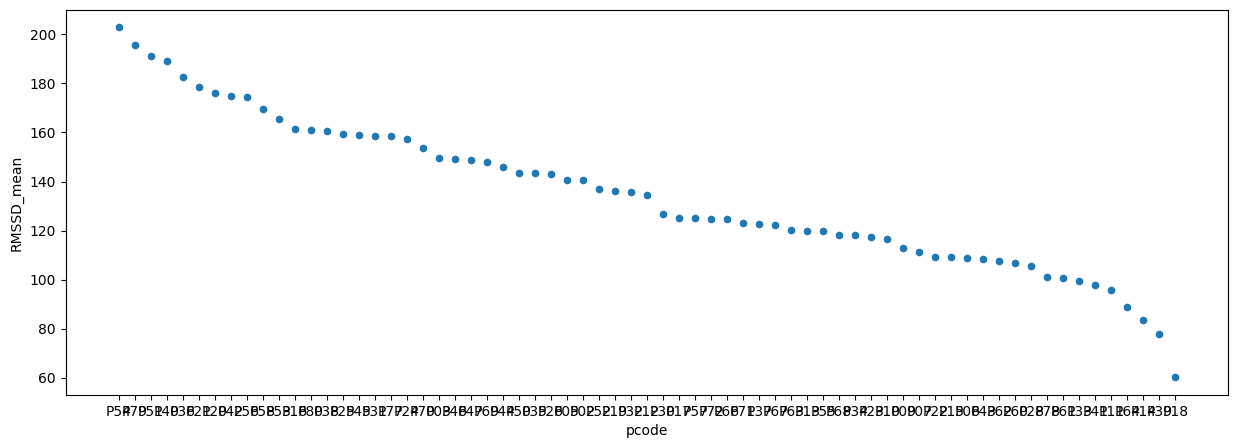

In [51]:

res.sort_values(by=measurement, ascending=False, inplace=True)
# res = res[4:64]
plot = res.plot(x='pcode', y=measurement, kind='scatter', figsize=(15, 5))

In [52]:
df_subj = pd.read_csv('dataset/SubjData/UserInfo.csv')
df_subj

,pcode,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,P01,2019-05-08,27,M,11,11,3,4,13,13,0,1
1,P02,2019-05-08,21,M,14,5,12,14,5,27,6,18
2,P03,2019-05-08,24,F,10,15,8,7,11,18,2,6
3,P04,2019-05-08,23,M,12,11,8,6,11,20,1,9
4,P05,2019-05-08,27,F,10,11,13,10,6,25,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...
72,P76,2019-04-30,18,M,8,8,12,6,8,21,14,21
73,P77,2019-04-30,18,M,11,12,7,11,10,7,2,7
74,P78,2019-04-30,17,M,12,11,9,12,10,10,2,7
75,P79,2019-04-30,23,M,9,10,7,12,11,13,2,6


In [53]:
personality_traits = ['openness', 'conscientiousness', 'neuroticism', 'extraversion', 'agreeableness']
df_test = pd.merge(res, df_subj, on='pcode')

Path(output_path).mkdir(parents=True, exist_ok=True)

df_test.to_csv(f'{output_path}hrv-results.csv', index=False)

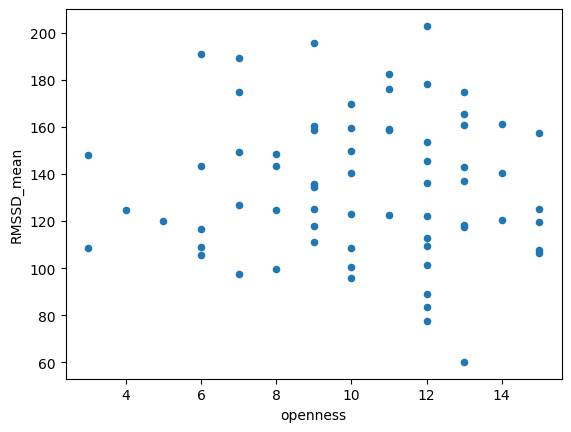

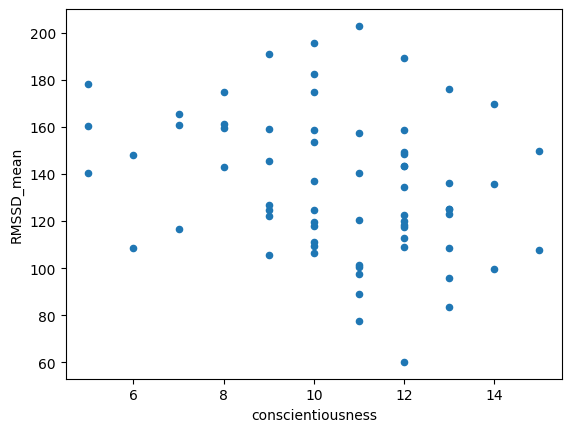

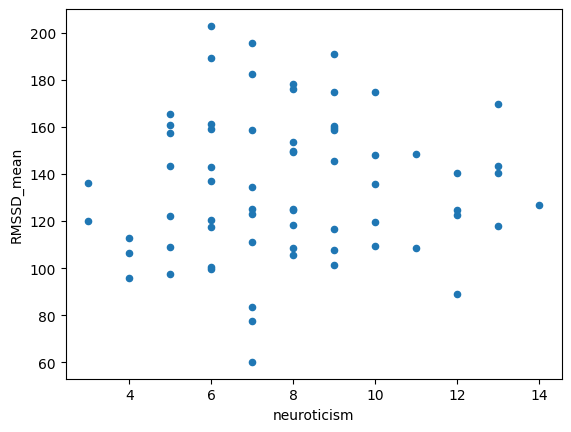

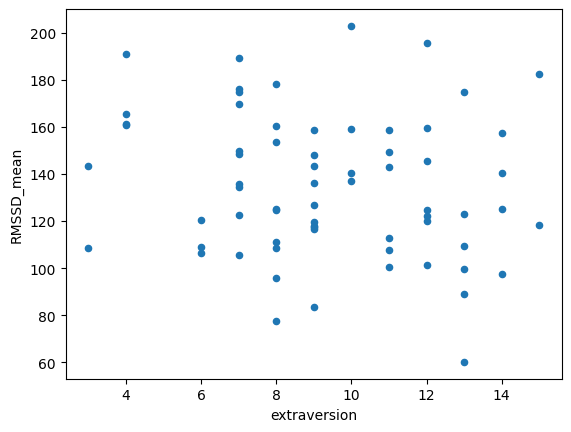

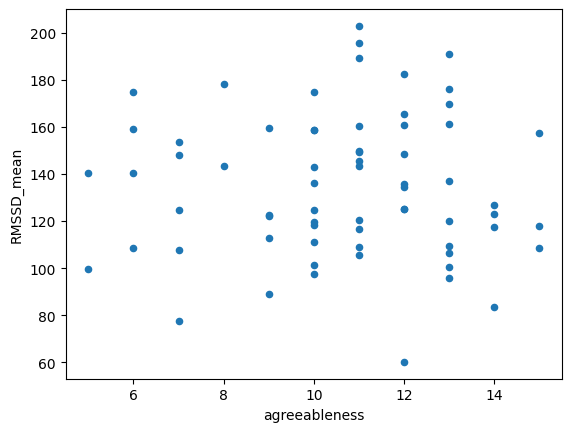

In [54]:
for trait in personality_traits:
    df_test.plot(x=trait, y=measurement, kind='scatter')


In [55]:
import statsmodels.api as sm

X = df_test[personality_traits]
y = df_test[measurement]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             RMSSD_mean   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.285
Date:                Wed, 12 Jun 2024   Prob (F-statistic):              0.282
Time:                        22:29:33   Log-Likelihood:                -320.04
No. Observations:                  67   AIC:                             652.1
Df Residuals:                      61   BIC:                             665.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               174.1553     31.19

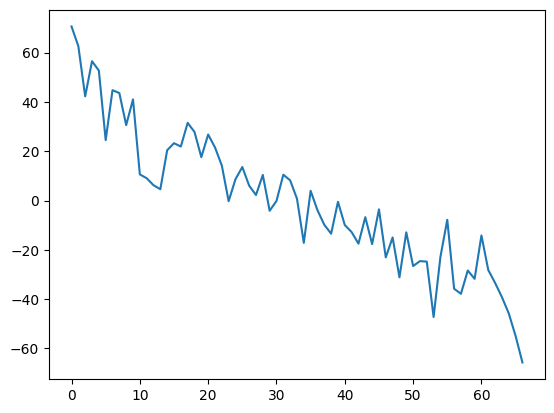

In [56]:
plot = plt.plot(results.resid)

ShapiroResult(statistic=0.9924302923212162, pvalue=0.9585087264355493)


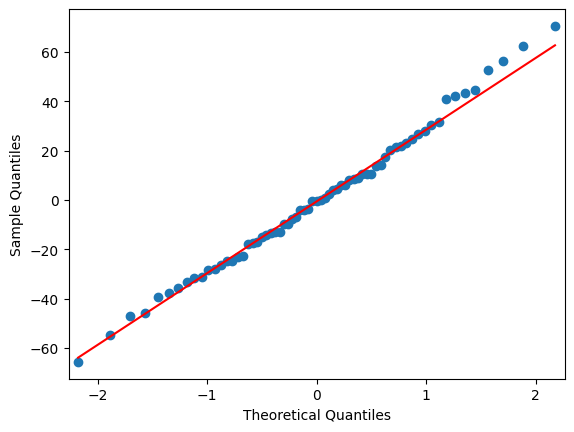

In [57]:
print(scipy.stats.shapiro(results.resid))
qq_plot = sm.qqplot(results.resid, line='q')

In [58]:
for trait in personality_traits:
    print(trait, scipy.stats.pearsonr(df_test[trait], df_test[measurement]))

openness PearsonRResult(statistic=-0.04166611107459809, pvalue=0.7377917963036033)
conscientiousness PearsonRResult(statistic=-0.2706002718265805, pvalue=0.02677561439565722)
neuroticism PearsonRResult(statistic=0.05208268235779598, pvalue=0.6755255871164735)
extraversion PearsonRResult(statistic=-0.17200490729382578, pvalue=0.1639760395702031)
agreeableness PearsonRResult(statistic=-0.011135226574197243, pvalue=0.9287376149929224)


In [59]:
df_corr = df_test[personality_traits]
print(df_corr.corr(method='pearson'))

df_corr.corr(method='pearson').to_csv(f"{output_path}IV-correlation.csv", index=False)

                   openness  conscientiousness  neuroticism  extraversion  \
openness           1.000000           0.087493    -0.237500      0.196634   
conscientiousness  0.087493           1.000000    -0.159307      0.128341   
neuroticism       -0.237500          -0.159307     1.000000     -0.059101   
extraversion       0.196634           0.128341    -0.059101      1.000000   
agreeableness      0.107656           0.279199    -0.234641     -0.071584   

                   agreeableness  
openness                0.107656  
conscientiousness       0.279199  
neuroticism            -0.234641  
extraversion           -0.071584  
agreeableness           1.000000  


{'Lagrange multiplier statistic': 11.14820630392024, 'p-value': 0.9422881213546203, 'f-value': 0.45908775353827685, 'f p-value': 0.9694294036735293}


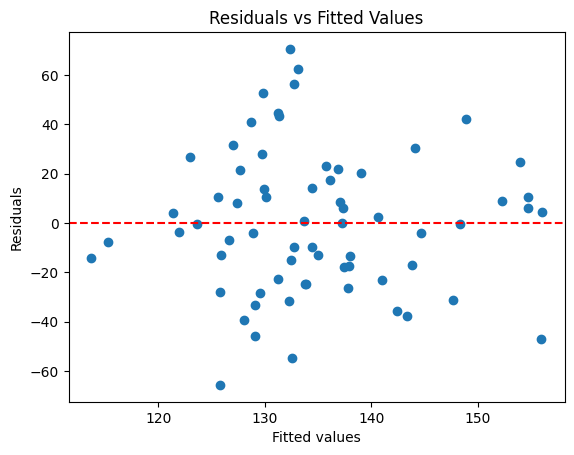

In [60]:
from statsmodels.stats.diagnostic import het_white

homogeneity_test_results = het_white(results.resid, results.model.exog)

labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
homogeneity_test_results = dict(zip(labels, homogeneity_test_results))

print(homogeneity_test_results)

plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()